# TUGAS AKHIR

## Database - AdventureWorks
`AdventureWorks` adalah contoh database yang disediakan oleh Microsoft, yang dirancang untuk memperlihatkan fitur-fitur dari sistem manajemen database. Database ini menggambarkan perusahaan manufaktur sepeda fixie dan mencakup tabel-tabel terkait produk, penjualan, pelanggan, karyawan, dan lain-lain. 

Dikarenakan database `adventureworks` adalah database yang kompleks yang memiliki banyak sekali hal yang bisa dianalisa maka dalam tugas akhir ini kami fokuskan untuk analisa penjualan saja. dan akan menghasilkan output berupa :
* Penjualan Bulanan
* Penjualan Berdasarkan Kategori Produk
* Penjualan Berdasarkan Produk Tertinggi
* Penjualan Berdasarkan Wilayah (10 Terbesar dan 10 Terendah)
* 10 Pelanggan dengan pembelian terbesar
* Penjualan Berdasarkan Jenis Kartu Kredit
* Distribusi Penjualan Berdasarkan Jenis Pelanggan (Store dan Individual)

## ERD Database AdventureWorks

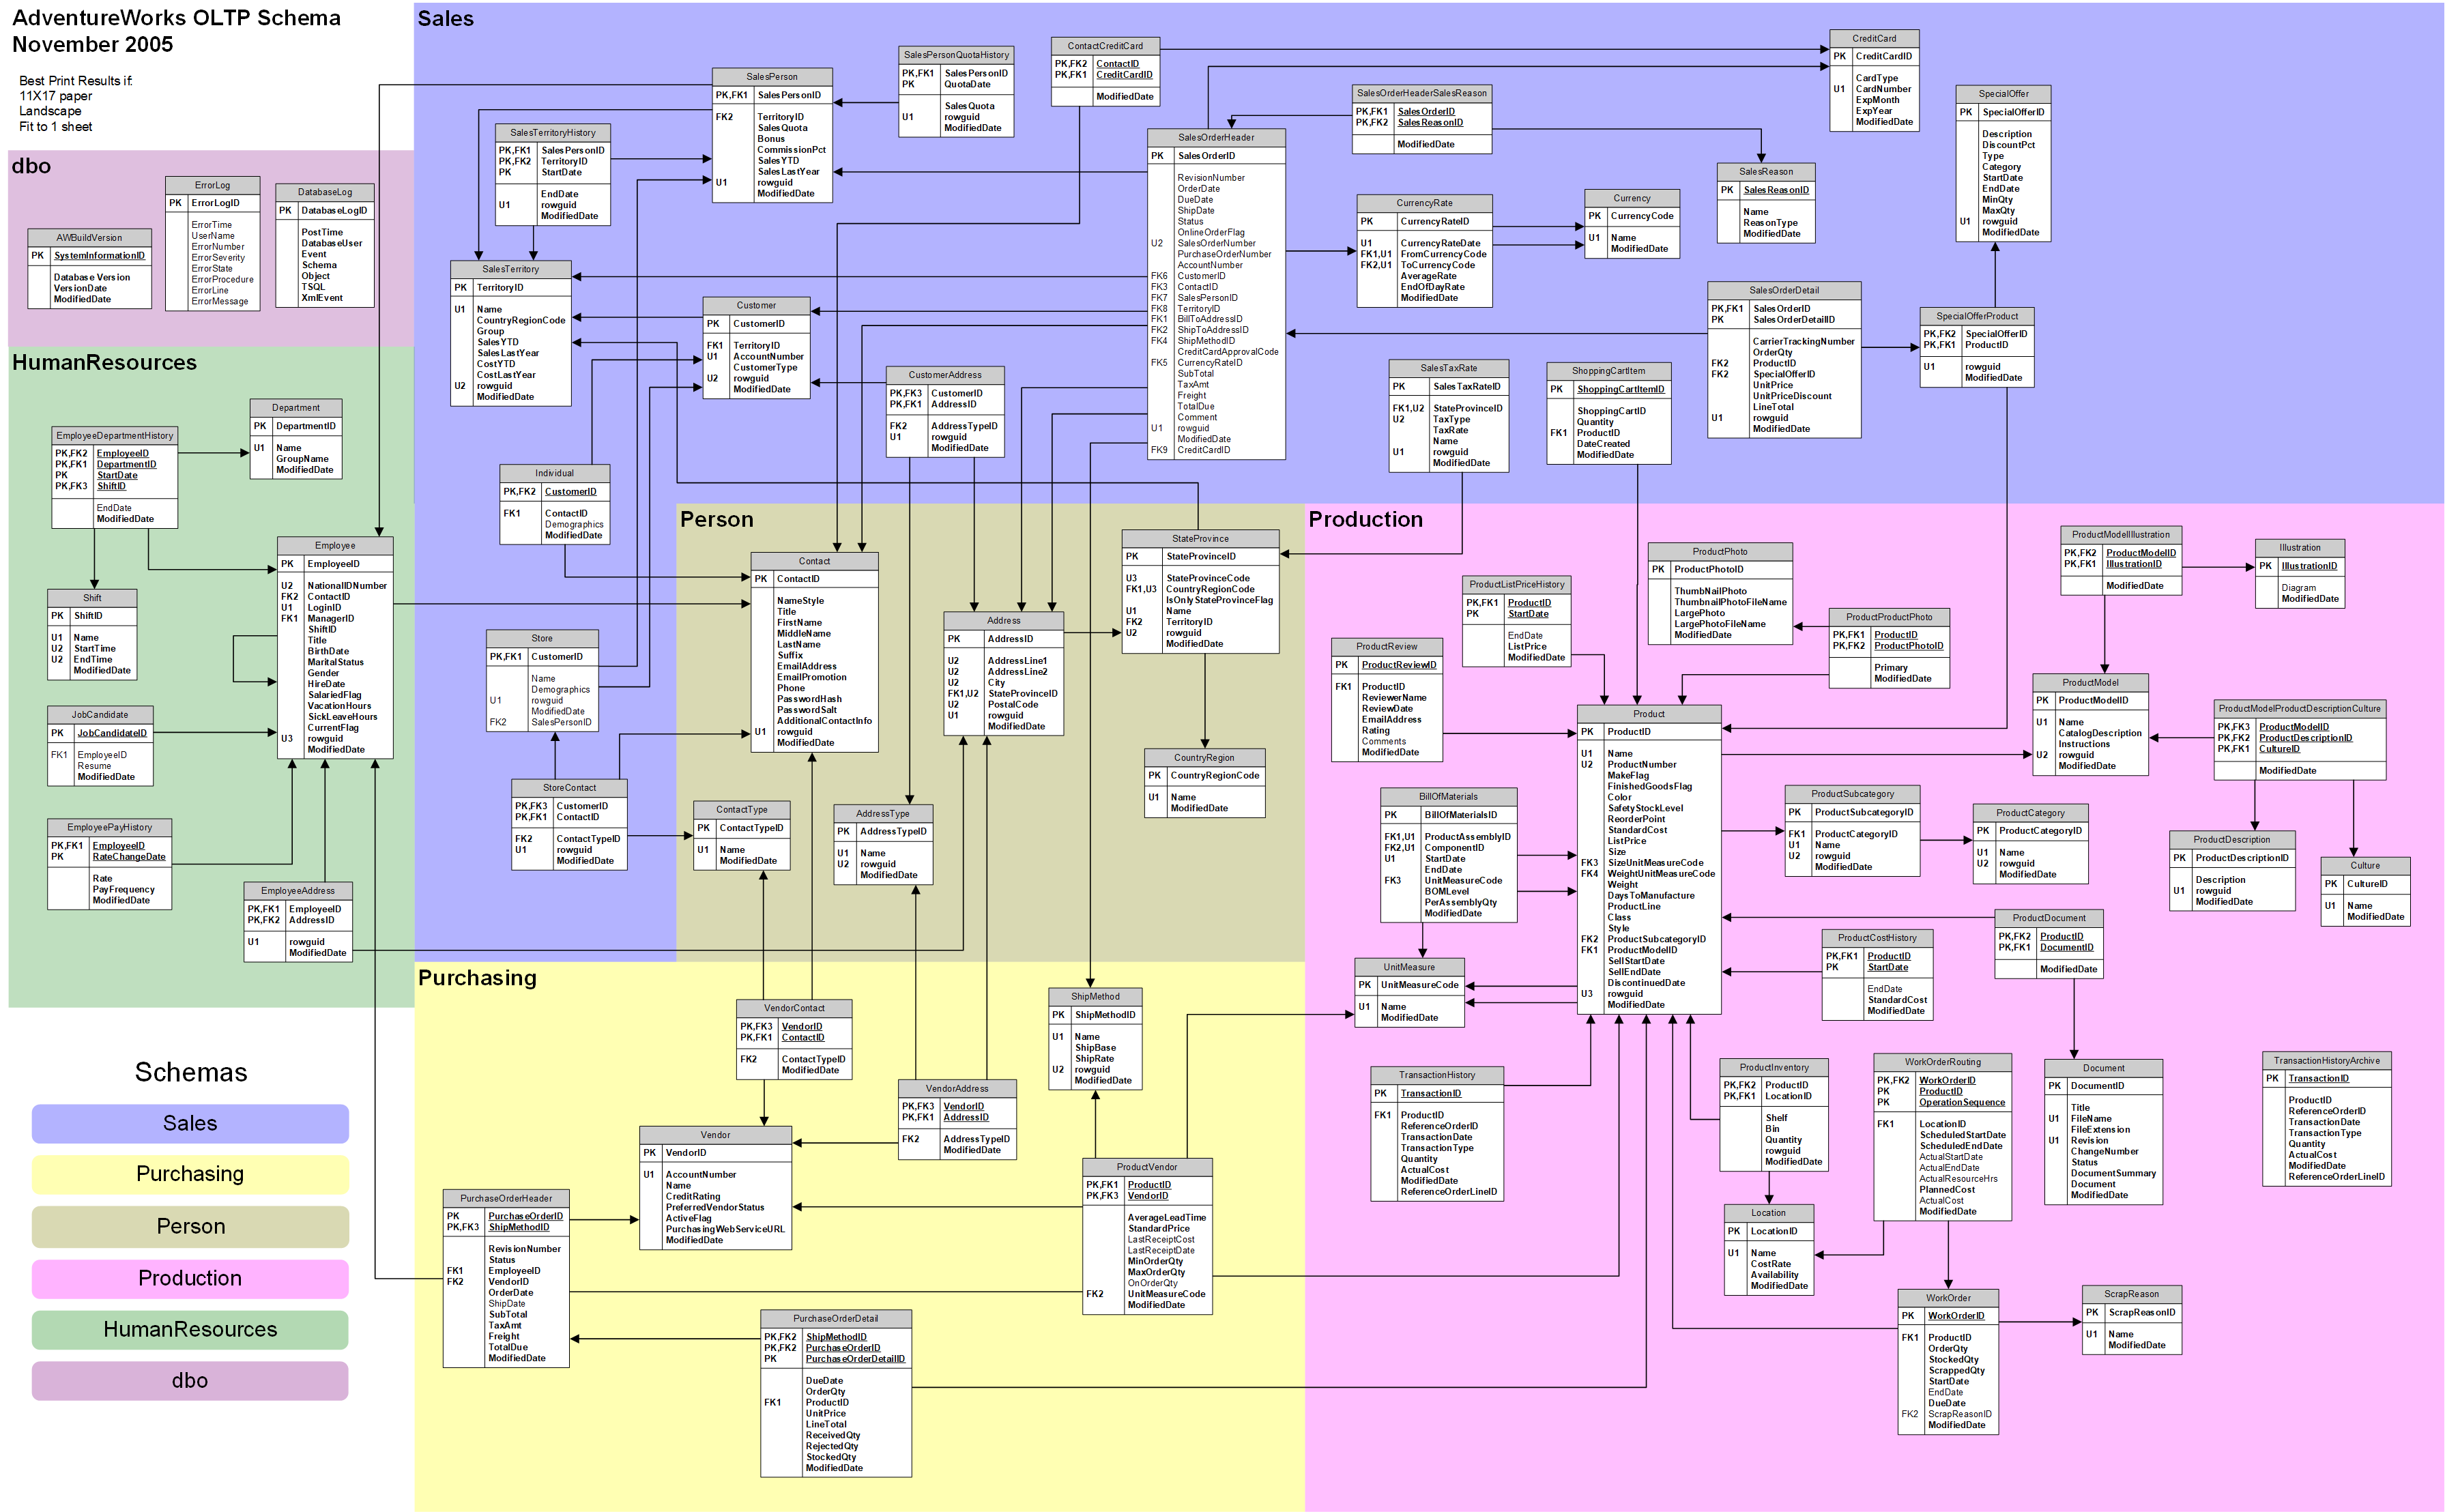

In [3]:
from IPython.display import display
from PIL import Image


path="AdvWorks.webp"
display(Image.open(path))

## Import Library
Dalam tugas akhir ini digunakan beberapa library yakni `pandas`, `matplotlib`,`numpy` dan `sqlalchemy` untuk mengkoneksikan langsung dengan database dikarenakan `pandas` lebih support menggunakan `sqlalchemy` ketimbang menggunakan connection `mysql.connection`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from babel.numbers import format_number

## Membuat Koneksi Dengan Database
Untuk membuat koneksi dengan database bisa dilakukan dengan beberapa cara, pada tugas akhir ini digunakan cara koneksi menggunakan SQLAlchemy

In [2]:
# Membuat koneksi ke MySQL database menggunakan SQLAlchemy
host = 'localhost'
username = 'root'
password = 'rootgip'
database = 'adventureworks'

# Membuat URI string koneksi
uri = f'mysql+mysqlconnector://{username}:{password}@{host}/{database}'

# Membuat engine menggunakan SQLAlchemy
engine = create_engine(uri)

#Format Number karena angka penjualan bisa sampai jutaan
def format_angka(number):
    if number < 1000:
        return str(number)
    elif number < 1000000:
        return '{:.1f}K'.format(number / 1000)
    else:
        return '{:.1f}M'.format(number / 1000000)

## Analisis Penjualan Bulanan

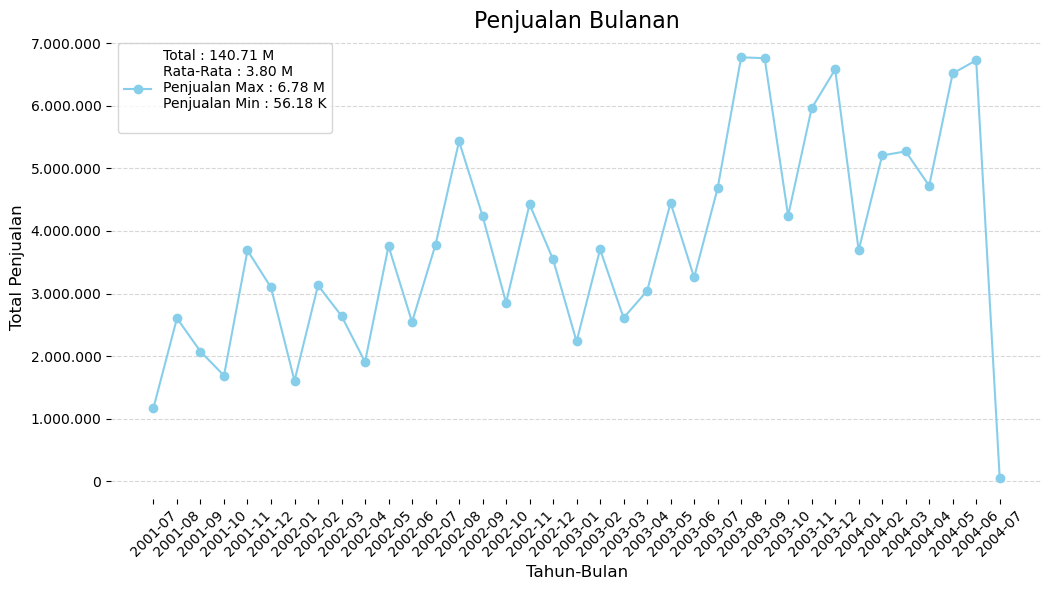

In [31]:

# Query untuk mengambil data penjualan
query = """
SELECT OrderDate, TotalDue
FROM SalesOrderHeader
"""
df = pd.read_sql_query(query, engine)

# Mengubah kolom OrderDate menjadi tipe data datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Mengambil bulan dan tahun dari kolom OrderDate
df['BulanTahun'] = df['OrderDate'].dt.to_period('M')

# Menghitung total penjualan bulanan
penjualan_bulanan = df.groupby('BulanTahun')['TotalDue'].sum()

penjualan_bulanan.mean()

# Mengatur tampilan grafik
plt.figure(figsize=(10, 6))

plt.plot(penjualan_bulanan.index.astype(str), penjualan_bulanan, marker='o', linestyle='-', color='skyblue')

plt.title('Penjualan Bulanan', fontsize=16)
plt.xlabel('Tahun-Bulan', fontsize=12)
plt.ylabel('Total Penjualan', fontsize=12)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.box(False)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

plt.legend(
           loc='upper left',
           labels=[
               f'Total : {format_angka(penjualan_bulanan.sum())}\n' 
               f'Rata-Rata : {format_angka(penjualan_bulanan.mean())}\n'
               f'Penjualan Max : {format_angka(penjualan_bulanan.max())}\n'
               f'Penjualan Min : {format_angka(penjualan_bulanan.min())}\n'
           ])

# Menampilkan chart
plt.show()

Berdasarkan grafik dapat dikatakan bahwa penjualan dari bulan ke-bulan selama 2001-2004 terjadi secara fluktuatif, tetapi mulai menurun secara signifikan pada pertengahan 2004 hal ini disebabkan karena adanya penjualan untuk accessories dan clothing pada bulan juni 2004 sedangkan penjualan Bike dan Component berhenti sampai bulan Mei 2004

## Analisis Penjualan Berdasarkan Kategori Produk

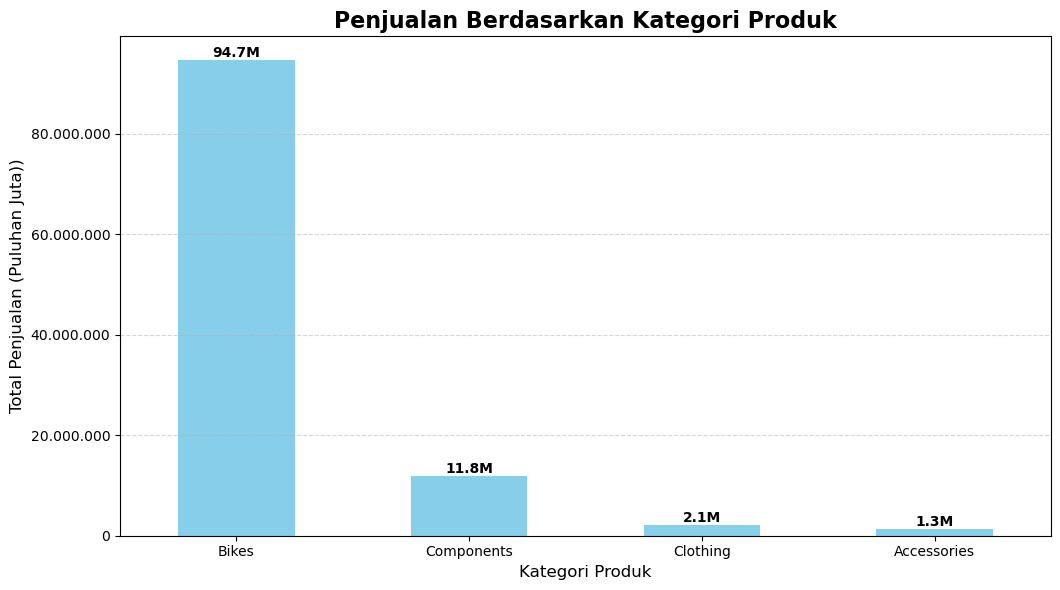

In [4]:
query = """
SELECT pc.Name AS CategoryName, p.Name AS ProductName, sod.LineTotal
FROM SalesOrderDetail sod
JOIN Product p ON sod.ProductID = p.ProductID
JOIN ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
"""
df = pd.read_sql_query(query, engine)

# Menghitung total penjualan berdasarkan kategori produk
penjualan_per_kategori = df.groupby('CategoryName')['LineTotal'].sum().sort_values(ascending=False)

#b Mengatur tampilan grafik
plt.figure(figsize=(10, 6))

ax = penjualan_per_kategori.plot(kind='bar', color='skyblue')

plt.title('Penjualan Berdasarkan Kategori Produk', fontsize=16, fontweight='bold')
plt.xlabel('Kategori Produk', fontsize=12)
plt.ylabel('Total Penjualan (Puluhan Juta))', fontsize=12)

plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

for i, value in enumerate(penjualan_per_kategori):
    plt.text(i, value, format_angka(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

Pendapatan Tertinggi Didapatkan dari Penjualan Sepeda sebesar 94,7 Juta, sedangkan untuk penjualan terendah didapatkan dari penjualan accessories sebesar 1,3 juta

### Penjualan Per Kategori Per Bulan

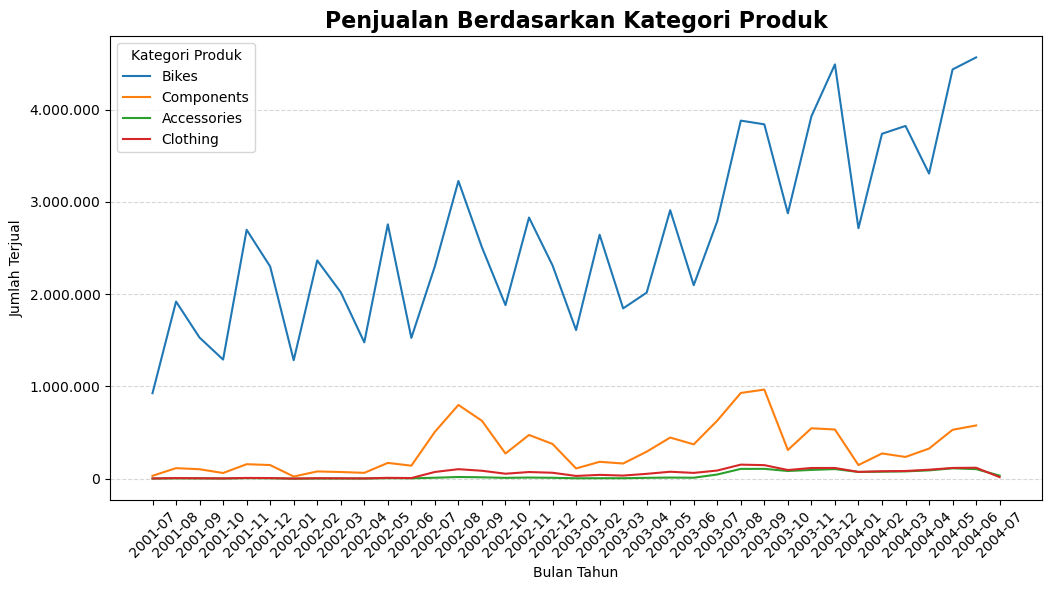

In [22]:
query = """
SELECT pc.Name, sod.LineTotal AS TotalSales, soh.OrderDate AS OrderDate
FROM SalesOrderDetail sod
JOIN SalesOrderHeader soh ON soh.SalesOrderID = sod.SalesOrderID
JOIN Product p ON sod.ProductID = p.ProductID
JOIN ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
ORDER BY TotalSales DESC
"""
df = pd.read_sql_query(query, engine)

# Mengubah kolom OrderDate menjadi tipe data datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Mengambil bulan dan tahun dari kolom OrderDate
df['BulanTahun'] = df['OrderDate'].dt.to_period('M')

produk = df['Name'].unique()

plt.figure(figsize=(10, 6))
for prod in produk:
    penjualan_per_bulan = df[df['Name'] == prod].groupby('BulanTahun')['TotalSales'].sum()
    plt.plot(penjualan_per_bulan.index.astype(str), penjualan_per_bulan.values, label=prod)

plt.title('Penjualan Berdasarkan Kategori Produk', fontsize=16, fontweight='bold')
plt.xlabel('Bulan Tahun')
plt.ylabel('Jumlah Terjual')
plt.legend(loc='upper left',title='Kategori Produk')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))
plt.show()

In [30]:
query = """
SELECT pc.Name, sod.LineTotal AS TotalSales, soh.OrderDate AS OrderDate
FROM SalesOrderDetail sod
JOIN SalesOrderHeader soh ON soh.SalesOrderID = sod.SalesOrderID
JOIN Product p ON sod.ProductID = p.ProductID
JOIN ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
ORDER BY TotalSales DESC
"""
df = pd.read_sql_query(query, engine)
# Mengubah kolom OrderDate menjadi tipe data datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Mengambil bulan dan tahun dari kolom OrderDate
df['BulanTahun'] = df['OrderDate'].dt.to_period('M')
produk = df['Name'].unique()

total_penjualan_kategori = df.groupby('Name')['TotalSales'].sum()
avg_penjualan_kategori = df.groupby('Name')['TotalSales'].mean()
max_penjualan_kategori = df.groupby('Name')['TotalSales'].max()
min_penjualan_kategori = df.groupby('Name')['TotalSales'].min()

Rangkum = pd.DataFrame({
    'Total Penjualan': total_penjualan_kategori,
    'Rata-rata Penjualan': avg_penjualan_kategori,
    'Maksimum Penjualan': max_penjualan_kategori,
    'Minimum Penjualan': min_penjualan_kategori
})

def format_angka(x):
    if x < 1000:
        return '{:.2f}'.format(x)
    elif x < 1000000:
        return '{:.2f} K'.format(x / 1000)
    else:
        return '{:.2f} M'.format(x / 1000000)
    
Rangkum_formatted = Rangkum.applymap(format_angka)

# Menampilkan dataframe 'Rangkum'
Rangkum_formatted

,Total Penjualan,Rata-rata Penjualan,Maksimum Penjualan,Minimum Penjualan
Name,,,,
Accessories,1.27 M,30.88,1.57 K,1.37
Bikes,94.65 M,2.36 K,27.89 K,67.80
Clothing,2.12 M,99.12,1.26 K,5.19
Components,11.80 M,631.22,12.06 K,12.14


Terlihat bahawa penjualan dari bulan Juli 2001 – Juni 2004 terjadi secara fluktuatif.

* Sepeda adalah produk yang paling banyak terjual dan jauh lebih tinggi dari produk lainnya.
* Pakaian dan aksesoris adalah produk yang paling sedikit terjual.

`Hal ini menunjukkan, pembeli cendrung hanya membeli sepeda tanpa perlengkapan lainnya, seperti pakaian untuk bersepeda dan aksesoris tambahan pada sepeda.`

### 15 Produk Terlaris

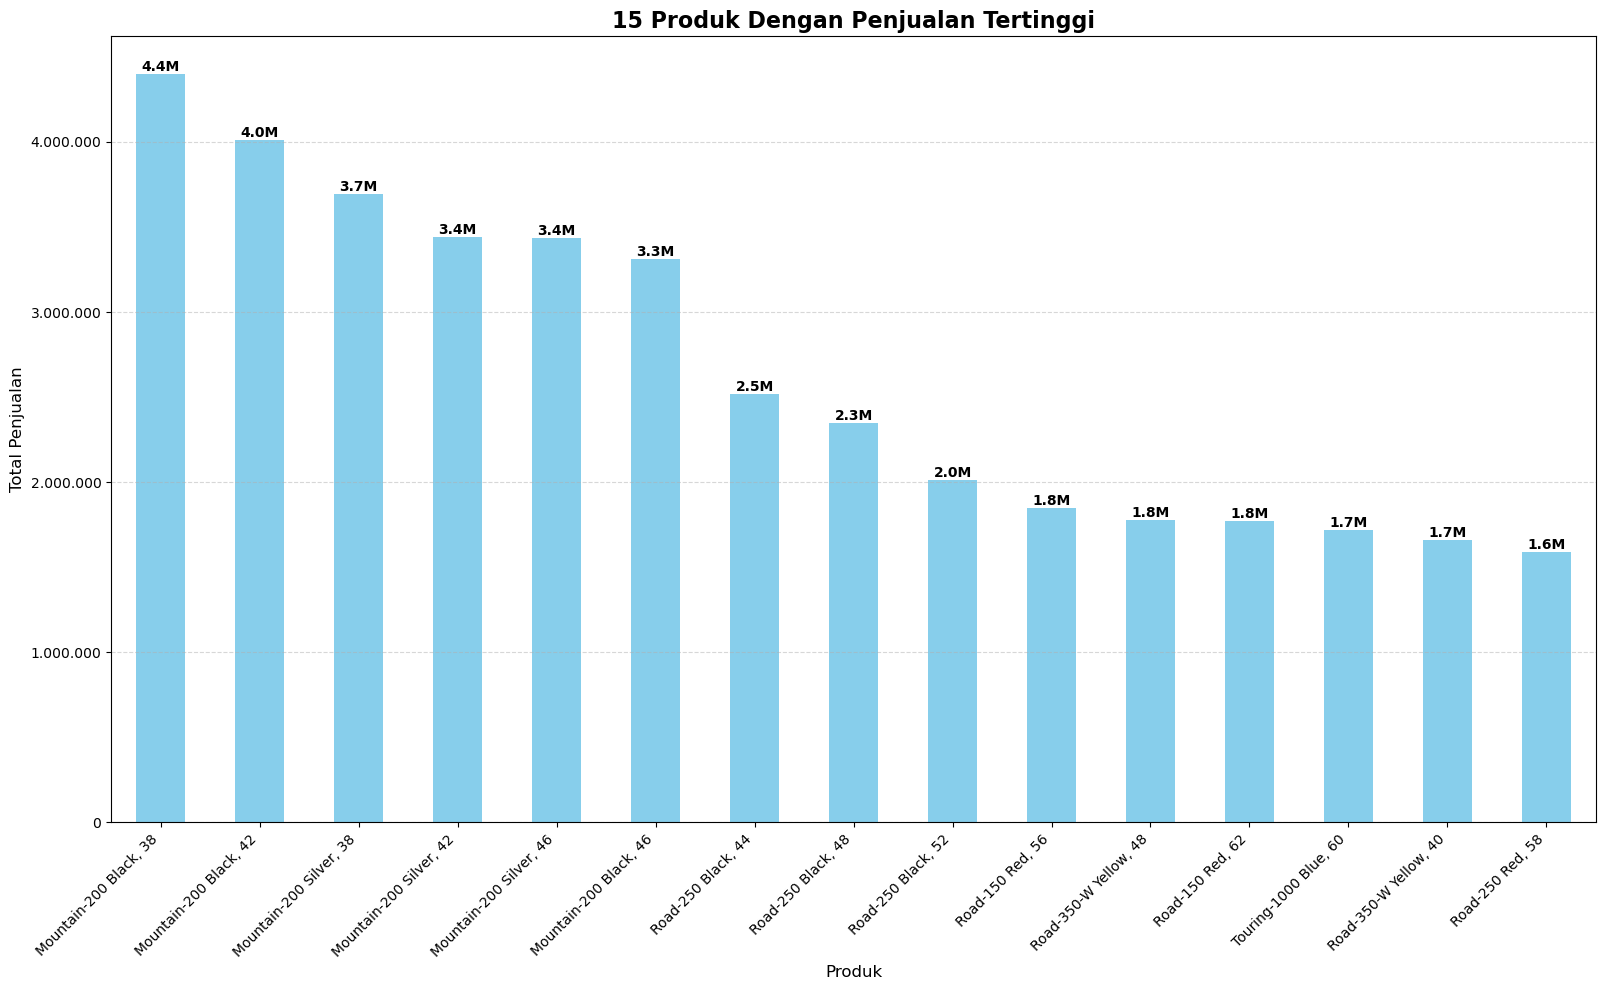

In [23]:
query = """
SELECT pc.Name AS CategoryName, p.Name AS ProductName, sod.LineTotal
FROM SalesOrderDetail sod
JOIN Product p ON sod.ProductID = p.ProductID
JOIN ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
"""
df = pd.read_sql_query(query, engine)

# Menghitung total penjualan berdasarkan kategori produk
produk = df.groupby('ProductName')['LineTotal'].sum().sort_values(ascending=False)

produk_terlaris = produk.head(15)

# Mengatur tampilan grafik
plt.figure(figsize=(14, 10))

ax = produk_terlaris.plot(kind='bar', color='skyblue')

plt.title('15 Produk Dengan Penjualan Tertinggi', fontsize=16, fontweight='bold')
plt.xlabel('Produk', fontsize=12)
plt.ylabel('Total Penjualan', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for i, value in enumerate(produk_terlaris):
    plt.text(i, value, format_angka(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

Secara keseluruhan, penjualan tertinggi didominasi oleh produk dengan kategori sepeda

## Analisis Penjualan Berdasarkan Wilayah

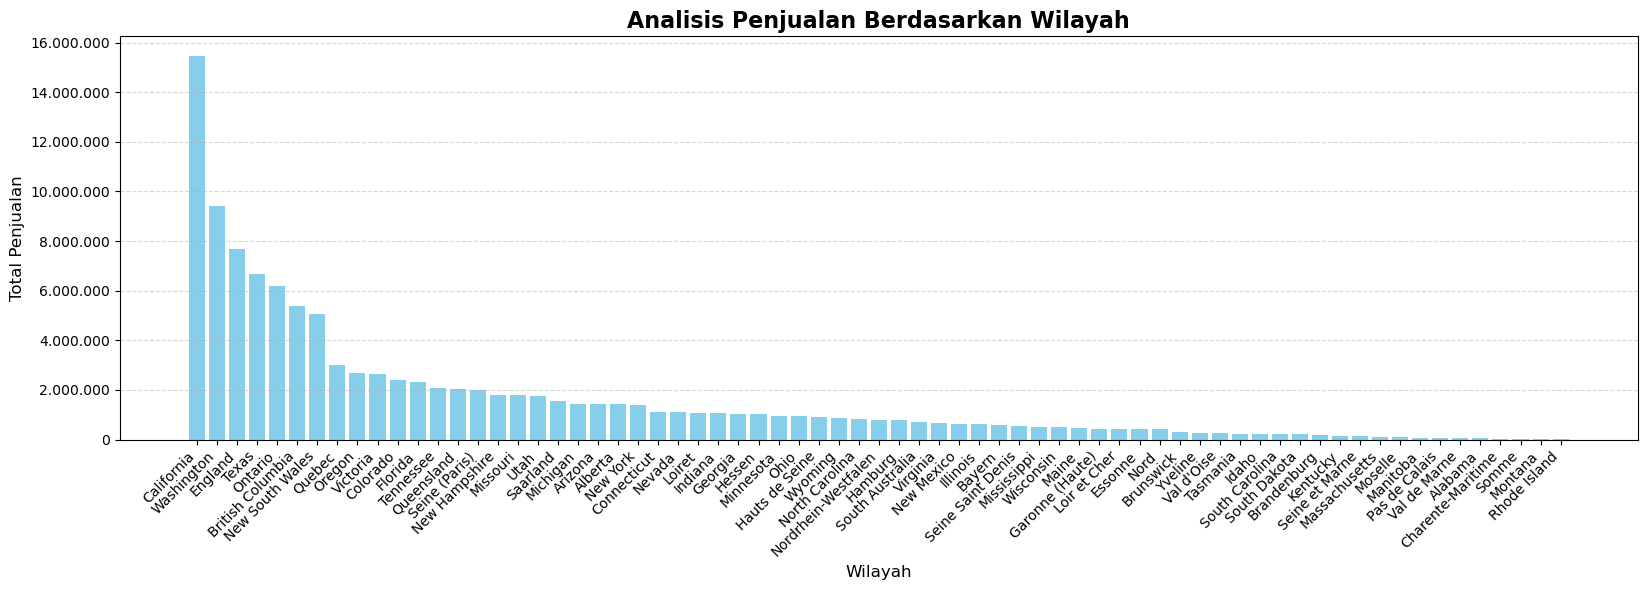

In [21]:
# Query untuk mengambil data penjualan
query = """
SELECT sa.Name AS StateProvinceName, sod.LineTotal
FROM SalesOrderDetail sod
JOIN SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
JOIN Address a ON soh.BillToAddressID = a.AddressID
JOIN StateProvince sa ON a.StateProvinceID = sa.StateProvinceID
"""

# Membaca data penjualan dari database
df = pd.read_sql_query(query, engine)

# Menghitung total penjualan berdasarkan wilayah
penjualan_per_wilayah = df.groupby('StateProvinceName')['LineTotal'].sum().sort_values(ascending=False)

# Mengatur tampilan grafik
plt.figure(figsize=(16, 6))

plt.bar(penjualan_per_wilayah.index, penjualan_per_wilayah, color='skyblue')

plt.title('Analisis Penjualan Berdasarkan Wilayah', fontsize=16, fontweight='bold')
plt.xlabel('Wilayah', fontsize=12)
plt.ylabel('Total Penjualan', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

# #1 California
Menjadi wilayah dengan Total penjualan tertinggi serta memiliki penjualan jauh lebih tinggi dari wilayah lainnya

### 10 Wilayah Penjualan Tertinggi

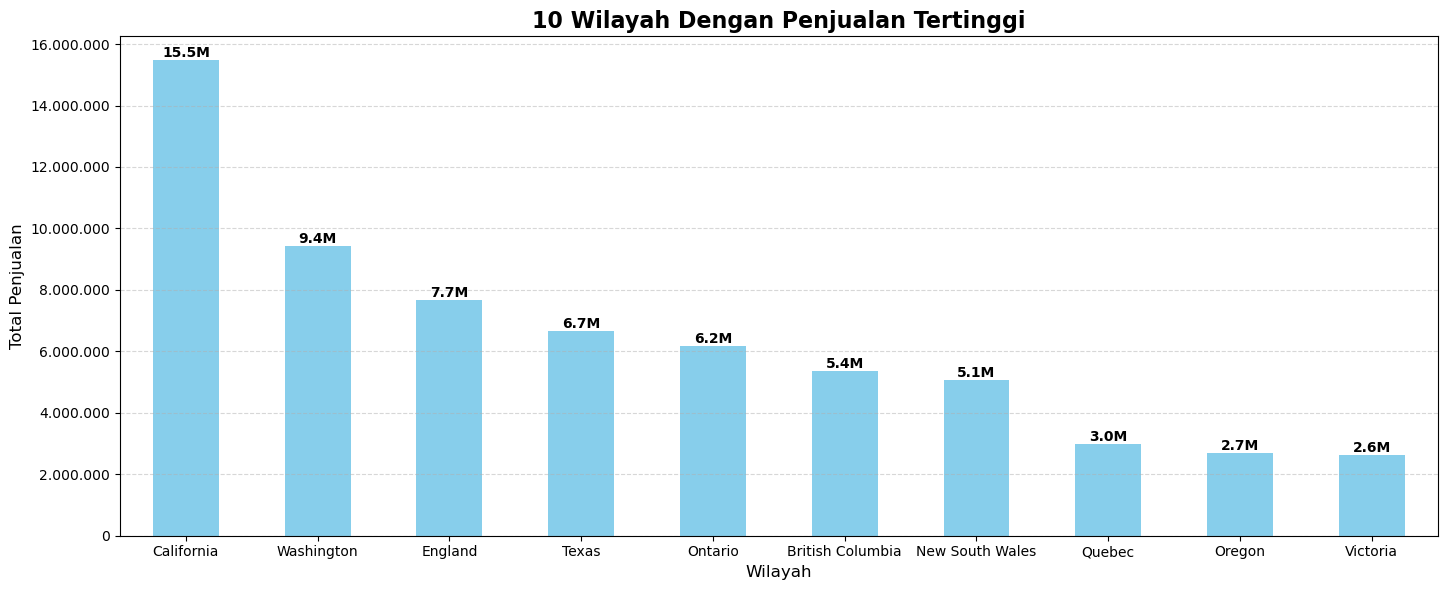

In [22]:
top_10_wilayah = penjualan_per_wilayah.head(10)

# Mengatur tampilan grafik
plt.figure(figsize=(14, 6))

ax = top_10_wilayah.plot(kind='bar', color='skyblue')

plt.title('10 Wilayah Dengan Penjualan Tertinggi', fontsize=16, fontweight='bold')
plt.xlabel('Wilayah', fontsize=12)
plt.ylabel('Total Penjualan', fontsize=12)

plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(fontsize=10)

#Menampilkan Angka Penjualan
for i, value in enumerate(top_10_wilayah):
    plt.text(i, value, format_angka(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

### 10 Wilayah Penjualan Terendah

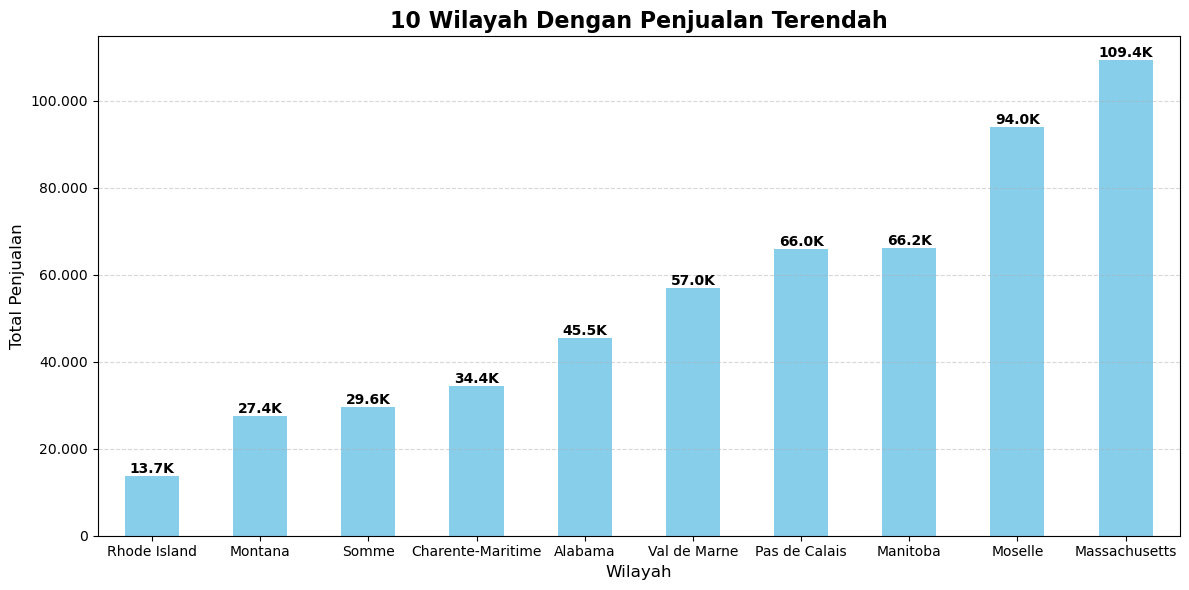

In [24]:
terendah_10_wilayah = penjualan_per_wilayah.tail(10).sort_values(ascending=True)

# Mengatur tampilan grafik
plt.figure(figsize=(12, 6))

ax = terendah_10_wilayah.plot(kind='bar', color='skyblue')

plt.title('10 Wilayah Dengan Penjualan Terendah', fontsize=16, fontweight='bold')
plt.xlabel('Wilayah', fontsize=12)
plt.ylabel('Total Penjualan', fontsize=12)

plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(fontsize=10)

#Menampilkan Angka Penjualan
for i, value in enumerate(terendah_10_wilayah):
    plt.text(i, value, format_angka(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

Penjualan tertinggi berada di wilayah California. Dengan penjualan mencapai 15,5 juta.
### 1000X Lebih tinggi 
dari Penjualan terendah yang berada di wilayah Rhode Island. Dengan penjualan hanya mencapai 13,7 ribu.

### 10 Pelanggan dengan Pembelian Tertinggi

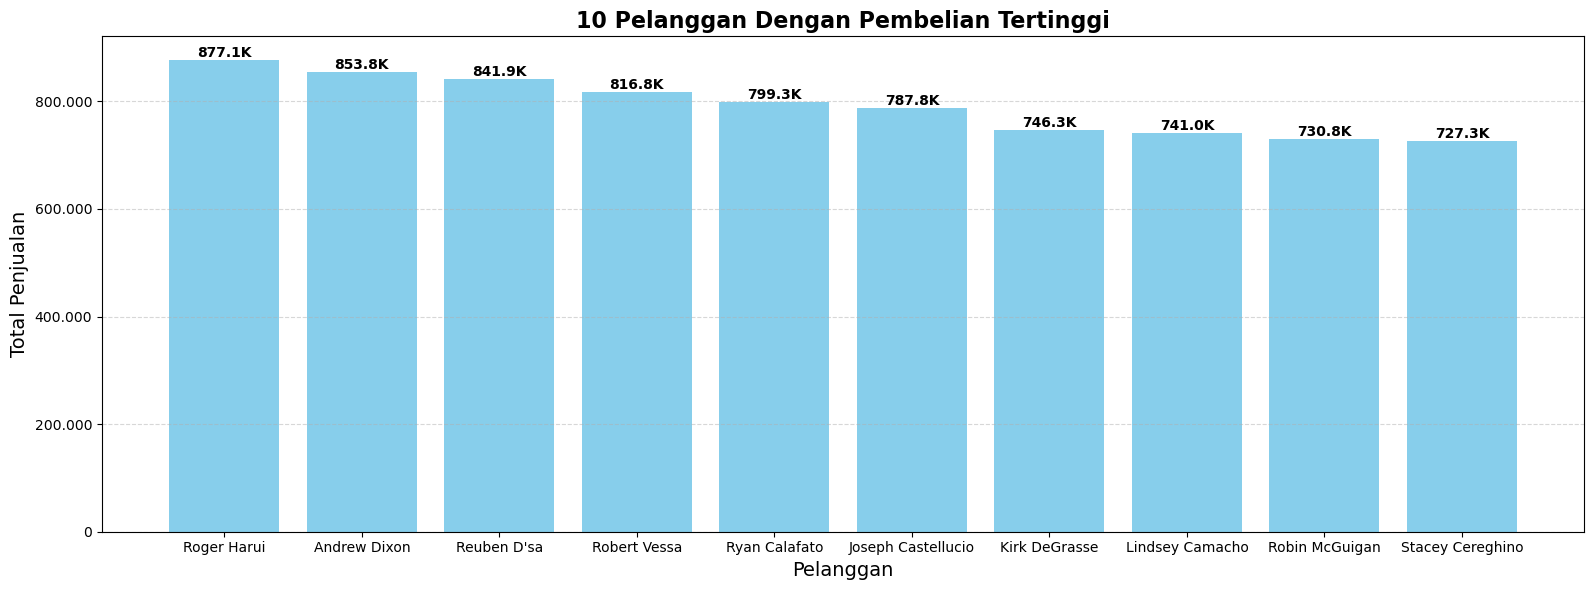

In [7]:
# Query untuk mengambil data penjualan
query = """
SELECT c.ContactID, CONCAT(c.FirstName, ' ', c.LastName) AS CustomerName, SUM(sod.LineTotal) AS TotalSales
FROM SalesOrderDetail sod
JOIN SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
JOIN Contact c ON soh.ContactID = c.ContactID
GROUP BY c.ContactID, CustomerName
ORDER BY TotalSales DESC
"""

df = pd.read_sql_query(query, engine)

# Mengambil 10 pelanggan dengan penjualan tertinggi
top_10_pelanggan = df.head(10)

# Mengatur tampilan grafik
plt.figure(figsize=(16, 6))

plt.bar(top_10_pelanggan['CustomerName'], top_10_pelanggan['TotalSales'], color='skyblue')

plt.title('10 Pelanggan Dengan Pembelian Tertinggi', fontsize=16, fontweight='bold')
plt.xlabel('Pelanggan', fontsize=14)
plt.ylabel('Total Penjualan', fontsize=14)

plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(fontsize=10)

#Menampilkan Angka Penjualan
for i, value in enumerate(top_10_pelanggan['TotalSales']):
    formatted_value = format_angka(value)
    plt.text(i, value, formatted_value, ha='center', va='bottom', fontweight='bold')
    
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

# Menampilkan chart
plt.show()

Berdasarkan data 10 pelanggan dengan pembelian tertinggi diketahui daya beli maksimal pelanggan mencapai 877,1 ribu. Dengan rata-rata 792,1 ribu.


### Total Penjualan Unit Price Dengan Total Nilai

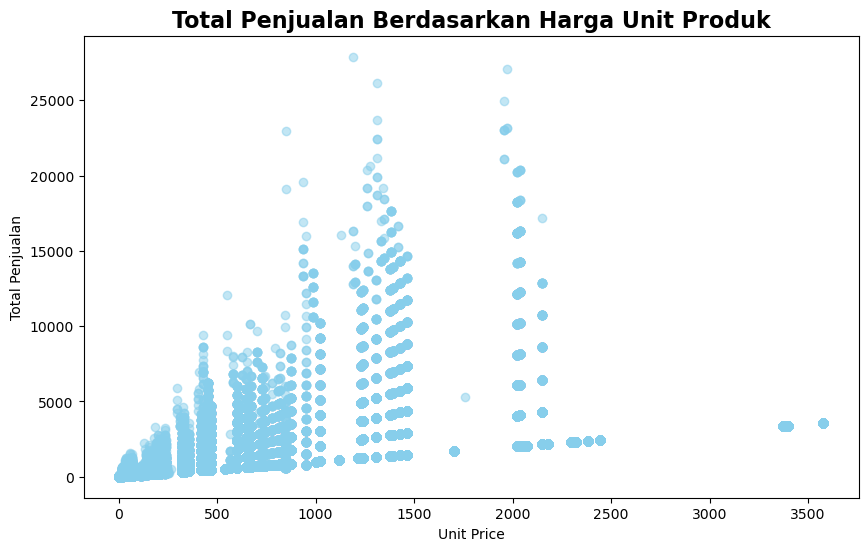

In [15]:
# Query untuk mengambil data penjualan dari tabel SalesOrderHeader, SalesOrderDetail, dan Product
query = """
    SELECT sod.UnitPrice, sod.LineTotal, p.Name
    FROM SalesOrderHeader soh
    INNER JOIN SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    INNER JOIN Product p ON sod.ProductID = p.ProductID
"""

# Membaca data dari database ke DataFrame
df = pd.read_sql(query, engine)

# Mengubah format kolom LineTotal menjadi numerik
df['LineTotal'] = pd.to_numeric(df['LineTotal'])

# Membuat scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['UnitPrice'], df['LineTotal'], c='skyblue', alpha=0.5)
plt.xlabel('Unit Price')
plt.ylabel('Total Penjualan')
plt.title('Total Penjualan Berdasarkan Harga Unit Produk', fontsize=16, fontweight='bold')
plt.show()

Banyak pelanggan lebih memilih untuk membeli produk dengan kategori harga menengah dan dengan Rentang harga yang dipilih adalah 500 – 1500 /unit

### Penjualan Berdasarkan Tipe Kartu Kredit

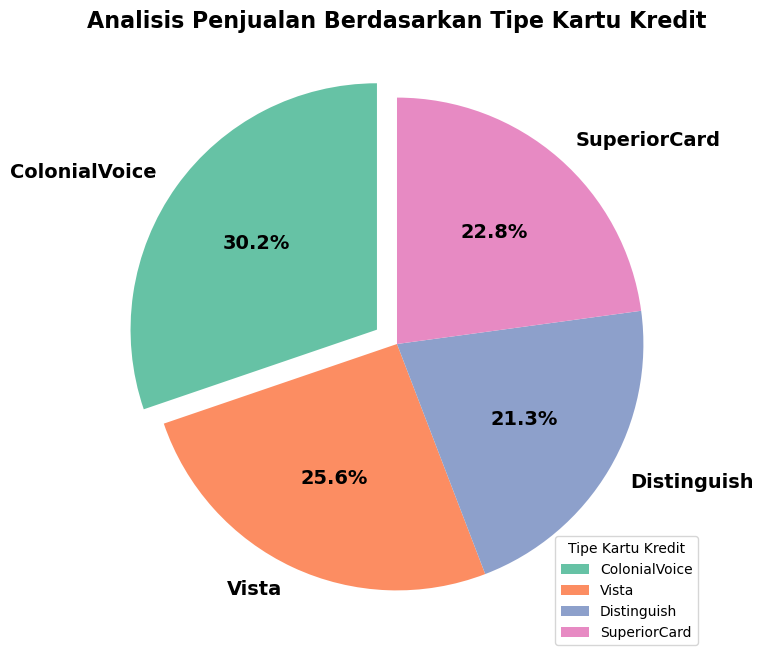

In [13]:
# Query untuk mengambil data penjualan berdasarkan tipe transaksi
query = """
SELECT cc.CardType, SUM(soh.TotalDue) AS TotalSales
FROM SalesOrderHeader soh
JOIN CreditCard cc ON soh.CreditCardID = cc.CreditCardID
GROUP BY CardType
"""

df = pd.read_sql_query(query, engine)

# Mengatur tampilan grafik
plt.figure(figsize=(10, 8))

colors = plt.cm.Set2.colors
explode = (0.1, 0, 0, 0)

plt.pie(df['TotalSales'], 
        labels=df['CardType'],
        colors=colors, 
        explode=explode, 
        autopct='%1.1f%%', 
        textprops={'fontsize':14, 'fontweight':'bold'},
        startangle=90)
plt.title('Analisis Penjualan Berdasarkan Tipe Kartu Kredit', fontsize=16, fontweight='bold')
plt.legend(title='Tipe Kartu Kredit', loc='lower right')

# Menampilkan chart
plt.show()


Mayoritas pembeli menggunakan kartu kredit dengan tipe Colonial Voice, yaitu sebesar 30.2%

### Distribusi Tipe Pelanggan

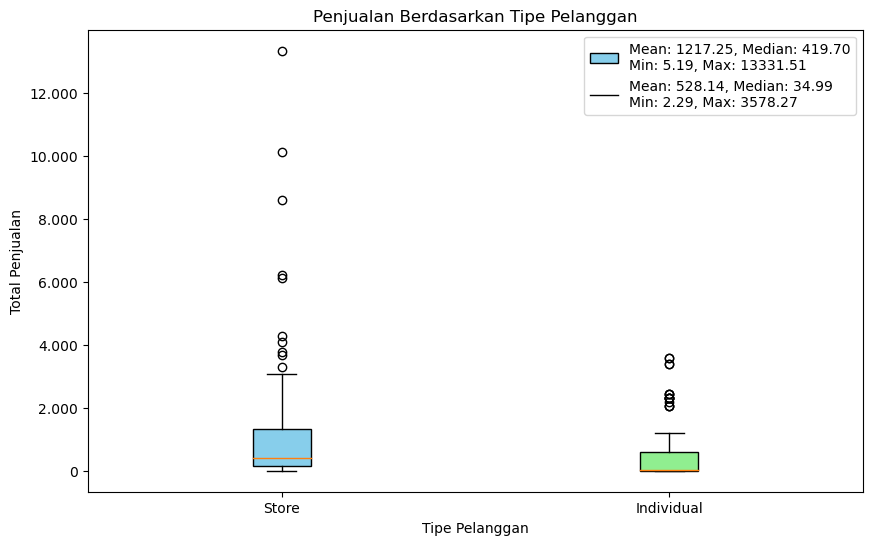

In [8]:
# Query untuk mengambil data penjualan dan tipe pelanggan
query = '''
        SELECT c.CustomerType, sod.LineTotal
        FROM SalesOrderHeader soh
        JOIN SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
        JOIN Customer c ON soh.CustomerID = c.CustomerID
        '''

# Membaca data dari database menggunakan pandas
df = pd.read_sql_query(query, engine)

# Membuat boxplot penjualan berdasarkan tipe pelanggan dengan 100 contoh data
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot([df[df['CustomerType'] == 'S']['LineTotal'].sample(n=100, random_state=1).values,
                       df[df['CustomerType'] == 'I']['LineTotal'].sample(n=100, random_state=1).values],
                       patch_artist=True)

colors = ['skyblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.xticks(ticks=[1, 2], labels=['Store', 'Individual'])
plt.xlabel('Tipe Pelanggan')
plt.ylabel('Total Penjualan')
plt.title('Penjualan Berdasarkan Tipe Pelanggan')

#Membuat Label
mean_values = [np.mean(df[df['CustomerType'] == 'S']['LineTotal'].sample(n=100, random_state=1).values),
               np.mean(df[df['CustomerType'] == 'I']['LineTotal'].sample(n=100, random_state=1).values)]
median_values = [np.median(df[df['CustomerType'] == 'S']['LineTotal'].sample(n=100, random_state=1).values),
                 np.median(df[df['CustomerType'] == 'I']['LineTotal'].sample(n=100, random_state=1).values)]
min_values = [np.min(df[df['CustomerType'] == 'S']['LineTotal'].sample(n=100, random_state=1).values),
              np.min(df[df['CustomerType'] == 'I']['LineTotal'].sample(n=100, random_state=1).values)]
max_values = [np.max(df[df['CustomerType'] == 'S']['LineTotal'].sample(n=100, random_state=1).values),
              np.max(df[df['CustomerType'] == 'I']['LineTotal'].sample(n=100, random_state=1).values)]

plt.legend(
           loc='upper right',
           labels=[
               f'Mean: {mean_values[0]:.2f}, Median: {median_values[0]:.2f}\nMin: {min_values[0]:.2f}, Max: {max_values[0]:.2f}',
               f'Mean: {mean_values[1]:.2f}, Median: {median_values[1]:.2f}\nMin: {min_values[1]:.2f}, Max: {max_values[1]:.2f}'
           ])

# Mengatur format angka pada sumbu y
plt.gca().get_yaxis().set_major_formatter(lambda x, p: format_number(x, locale='id_ID'))

plt.show()

Dari 100 pembelian, lebih dari 50% merupakan pelanggan Store (Toko). Pembeli dengan tipe Store lebih dominan dari pembelian individual.